In [1]:
include("../matrix_factorization.jl")
using Statistics, LinearAlgebra, Plots
using DelimitedFiles, Random

@profview matrix_factorization_experiment()

# Unlearing rule

Here the goal is to infer patterns from the coupling matrix $J$.
This problem is addressed to as "matrix factorization" since we have $J = \xi \xi^T$. <br>

In this first experiment we try the following algorithm:
- create a copy $J_{new}$ of $J$
- start from a random configuration $\sigma$;
- run two Monte Carlo simulation:
    - the first tries to minimize the energy of $\sigma$ using $J_{new}$ (the latter will be equal to $J$ at the first iteration);
    - take the output of the previous MC, let's say $\sigma_{new}$, and run a new MC using the original $J$;
- if the energy increases we stop the loop;
- otherwise we subtract the $\sigma_{new}$ configuration from $J_{new} -= \lambda \frac{\sigma_{new}^T \sigma }{N}$<br> 

The following is the chunk of code that we have just described (`recover_global_minimum` function)
```
...
 for t in 1:ntrials
    σnew = SH.monte_carlo(J_new, σ; nsweeps, earlystop = 0, β = 10, annealing)
    σnew = SH.monte_carlo(J, σnew; nsweeps, earlystop = 0, β = 10, annealing)
    Enew = SH.energy(J, σnew) / N

    if info
        @info "restart=$(r) trial=$(t)" E Enew SH.overlap(σ, σnew) Efinal
    end
    if Enew > E
        break
    end
    σ = σnew
    E = Enew
    J_new -= λ * σnew * σnew' ./ N
...
```
<br>

Check `matrix_factorization.jl` for details.

In [84]:
N = [1000] # N should be bigger
α = [0.04]
nsamples = 5000

p = factorization_probability(α, N; show = false, save = false)
println("Probability to recover one global minimum for N=$N = ", p)

Probability to recover one global minimum for N=[1000] = [0.266]


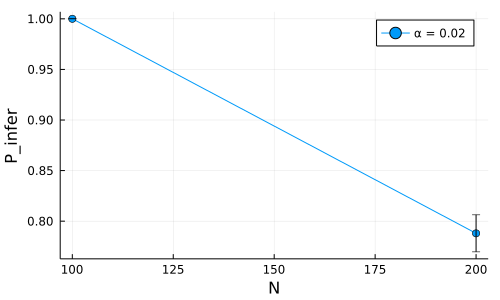

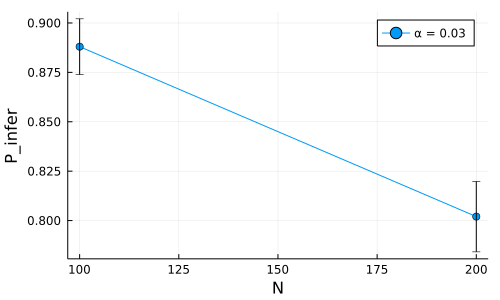

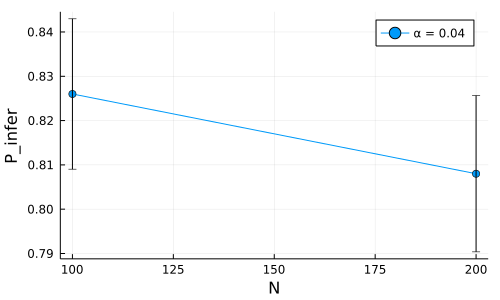

In [326]:
N = [1000] # N should be bigger
α = [0.04]
nsamples = 2000

p = factorization_probability(α, N; show = false, save = false, nrestarts = 10)
println("Probability to recover one global minimum for N=$N = ", p)

In [ ]:
N = [2000] # N should be bigger
α = [0.04]
nsamples = 2000

p = factorization_probability(α, N; show = false, save = false, nrestarts = 10)
println("Probability to recover one global minimum for N=$N = ", p)

In [3]:
α = 0.04
N = 1000
M = round(Int, N * α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

recover_global_minimum(J; ntrials = 10, info = true)

┌ Info: restart=1 trial=1
│   E = 0.0019400000000000034
│   Enew = -0.4554840000000004
│   SH.overlap(σ, σnew) = 0.078
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73
┌ Info: restart=1 trial=2
│   E = -0.4554840000000004
│   Enew = -0.45719600000000005
│   SH.overlap(σ, σnew) = 0.384
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73
┌ Info: restart=1 trial=3
│   E = -0.45719600000000005
│   Enew = -0.45612400000000003
│   SH.overlap(σ, σnew) = 0.216
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73


([-1, -1, 1, 1, -1, -1, -1, 1, 1, 1  …  -1, 1, -1, -1, -1, -1, -1, -1, 1, -1], -0.45719600000000005)

# Stopping times

We expect that the number of sweeps needed for the recovery of a global minumum grows exponentially as the size $N$ increases.<br>
Now we would like to show in a simplified way this behaviour.
We proceed as follows:
- take a range of `nsweeps`e.g. `[10, 20, 30, 40, 50,...]`;
- for each element in the list, we compute the factorization probability (i.e. the fraction of times that we recover a global minimum, see above);
- if the probability is $\geq 0.98$ we stop.

In this way we find the minimum number (not the exact value but a rough estimate) of sweeps that we need to recover at least a global minimum for a given size.

In [3]:
τ50 = stopping_time(; N = 50)

10

In [4]:
τ100 = stopping_time(; N = 100)

60

In [6]:
τ150 = stopping_time(; N = 150)

150

In [7]:
τ200 = stopping_time(; N = 200)

530

In [8]:
τ50 = readdlm("../julia_data/stopping_times/alpha_004/stop50.txt")[1]
τ70 = readdlm("../julia_data/stopping_times/alpha_004/stop70.txt")[1]
τ100 = readdlm("../julia_data/stopping_times/alpha_004/stop100.txt")[1]
τ150 = readdlm("../julia_data/stopping_times/alpha_004/stop150.txt")[1]
τ200 = readdlm("../julia_data/stopping_times/alpha_004/stop200.txt")[1]
τ250 = readdlm("../julia_data/stopping_times/alpha_004/stop250.txt")[1]

1000.0

In [11]:
N = [50, 150, 200, 250]
τ = [τ50, τ150, τ200, τ250]

4-element Vector{Float64}:
   10.0
  187.0
  248.0
 1000.0

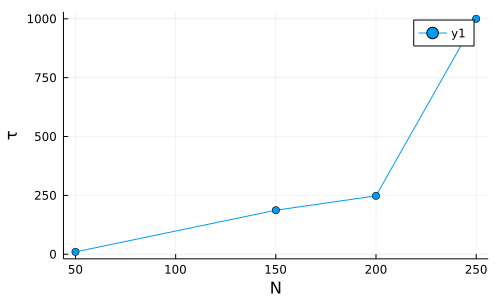

In [12]:
plot(N, τ, size = (500,300), markershape =:circle, xlabel = "N", ylabel = "τ")#, yscale=:log10)

## random stuff

M = 2
N = 10
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

ξ_new = zeros(Int64, (N,M))
ξ_new[1,:] = rand([-1,1], M)

J1 = N*J[:,1]


for i in 2:length(J1)
    q = round(Int64, (M + J1[i])/2)
    
    #q is the value of patterns such that the the spins 1 and i have the same values
    for j in 1:q
        ξ_new[i, j] = ξ_new[1, j]
    end
    for j in q+1:M
        ξ_new[i, j] = ξ_new[1, j]*(-1)
    end
    
end

Jb = SH.store(ξ_new)

J == Jb

ξ_new = zeros(Int64, (M,N))

ξ_new[1,:] = rand([-1,1], N)

ξ_new

M = 2
N = 3
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

J_new = SH.store(ξ_new)

# Minimize distance between matrices

Here we try a different approach. We start from a random $\xi$ of M patterns of size N and we try to minimize
$$
|| J - \xi \xi^T ||
$$
throug a zero-temperature MC.

In [20]:
Random.seed!(13)

N = 100
α = 0.1
M = round(Int, N*α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)
@time ξ_rec, dist = matrix_monte_carlo(J, M; nsweeps = 70)

  3.180245 seconds (263.13 k allocations: 2.539 GiB, 12.21% gc time, 3.13% compilation time)


([1 1 … -1 1; 1 1 … 1 1; … ; 1 -1 … 1 1; 1 -1 … -1 1], [4.488563244513772, 3.453925303187664, 2.692210987274214, 2.3315231073270537, 1.9764614845728716, 1.4243595051811884, 0.9516301802696255, 0.6216108107168021, 0.3959797974644666, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

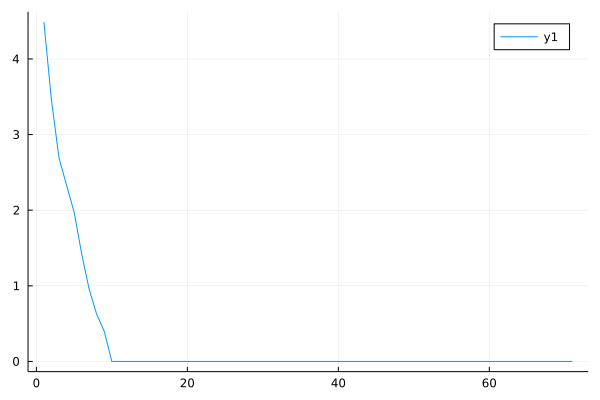

In [21]:
plot(dist)

In [30]:
α = 0.04
M = round(Int, N*α)
N = 200
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

@time ξ_rec, dist = matrix_monte_carlo(J, M; nsweeps = 70, earlystop = -1)

100.574562 seconds (1.46 M allocations: 103.455 GiB, 8.70% gc time, 0.01% compilation time)


([1 1 … -1 -1; 1 -1 … 1 -1; … ; -1 1 … 1 -1; 1 -1 … -1 -1], [4.000899898772775, 3.1729796721693635, 2.525549445170298, 2.063540646558725, 1.477294825009551, 1.072846680565308, 0.702993598832877, 0.19949937343260005, 0.19949937343260005, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [33]:
findfirst(x -> x ==0, dist)

10

In [34]:
J_rec = SH.store(ξ_rec)
J_rec == J

true

In [35]:
α = 0.04
M = round(Int, N*α)
N = 1000
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

@time ξ_rec, dist = matrix_monte_carlo(J, M; nsweeps = 100, earlystop = -1)

12634.323704 seconds (10.40 M allocations: 17.485 TiB, 11.17% gc time)


([1 1 … 1 1; -1 -1 … -1 1; … ; -1 -1 … -1 1; 1 -1 … 1 -1], [4.003857140308582, 3.285082647362164, 2.552695829902183, 1.9881227326299544, 1.5771366459505016, 1.3481453927525764, 1.2437845472588889, 1.2145385955168322, 1.206104473086805, 1.2026869916981722  …  1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368, 1.193904518795368])

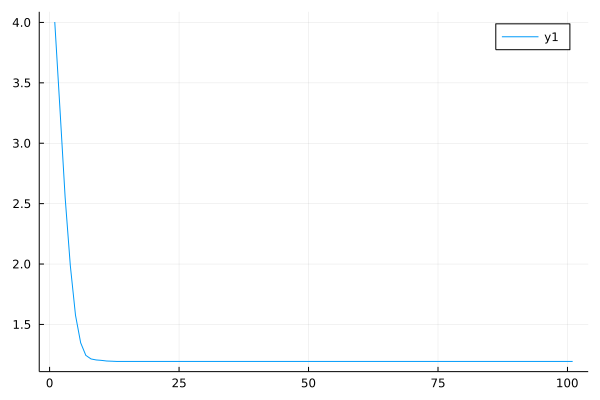

In [36]:
plot(dist)

In [97]:
α = 0.04
N = 200
M = round(Int, N*α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

@time matrix_monte_carlo(J, M; nsweeps = 30, β = 10^8, annealing = false)

 22.924422 seconds (312.03 k allocations: 22.170 GiB, 10.25% gc time)


([-1 -1 … 1 -1; -1 -1 … 1 -1; … ; -1 -1 … -1 1; 1 -1 … 1 1], [3.9660559753992377, 3.253920712002676, 2.726903005242394, 2.3354656923192, 2.0765355763867857, 1.8806381895516213, 1.7211042966653705, 1.5719414747375298, 1.3939153489362257, 1.2712198865656563  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], true)

## Experiment 2

In [6]:
N = 1000
α = 0.04
M = round(Int, N*α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)
σ = CH.init_pattern(N)
println(loss(σ, J))
σ_new = σ - 0.01 * loss_gradient(σ, J)
println(loss(σ_new, J))

1828.8408523193314
969.0536896001831


In [7]:
σ = gradient_descent(σ, J)

1828.8408523193314
406.5229789088753
347.9474722371919
300.72579148140636
257.5930021096377
218.5940261279735
184.0320618004533
153.9677114001301
128.20433463664898
106.39572593598476
88.13395702193976
72.98010056076065
60.47216037546437
50.15214267088493
41.61079811174927
34.518464092990264
28.62221079974087
23.71902640779138
19.6304889512153
16.1952550920929
13.276256301076687
10.769273426640433
8.602981851953999
6.729936420426544
5.114522825823202
3.724295884787078
2.5274009358337812
1.4943993725140041
0.6006328321712218
-0.17352729965600933
-0.8443016015887181
-1.4261466687971884
-1.9322102898875269
-2.3738112173928947
-2.75980686476625
-3.0964379269945335
-3.387739506202589
-3.636335737545252
-3.8443660489857767
-4.014295277186302
-4.149409676103925
-4.253910363362657
-4.332655722231932
-4.390710630742721
-4.432886569366431
-4.4634060279613195
-4.485740493455412
-4.50260095259368
-4.516026230353114
-4.527513698623526
-4.5381528305759575
-4.548740506273358
-4.559870783855276
-4.571

1000-element Vector{Float64}:
  0.998381821201737
  0.9837630617861846
 -0.9799801413914069
  1.0162364931692474
 -0.9941370502160126
  0.9790484955105351
  0.9775512806939763
  0.9966685160687737
 -0.9677940653082899
  0.999439859190375
  0.9790652901668567
 -0.9833119031131683
 -0.9826577249815547
  ⋮
 -1.0376218152890238
 -0.9718170966248397
 -0.9789003374472888
  1.0190801106547642
 -1.0297053844472561
 -1.01822720757705
  1.0221274487940661
  0.9978805290872015
 -1.006678214633888
  0.9932570392636488
  1.0073952462457232
 -1.0439201214765819

In [8]:
σ_rec = map(x -> round(Int, x), σ)
overlaps = (σ_rec' * ξ)/N

1×40 adjoint(::Vector{Float64}) with eltype Float64:
 0.058  -0.066  -0.056  -0.008  0.0  …  -0.022  0.008  0.048  -0.008  0.03

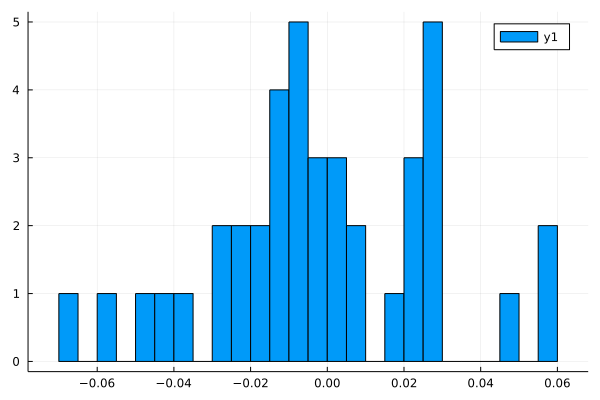

In [9]:
histogram(overlaps', nbins = 40)